In [1]:
# Install Prophet
import sys
!{sys.executable} -m pip install prophet

In [2]:
import glob
files = sorted(glob.glob("/Users/taeyounghwang/Downloads/**/invocations_per_function_md.anon.d*.csv", recursive=True))
print(len(files))
print(files[:3])

print("num files:", len(files))
print("first:", files[0] if files else None)
print("last:", files[-1] if files else None)

14
['/Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d01.csv', '/Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d02.csv', '/Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d03.csv']
num files: 14
first: /Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d01.csv
last: /Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d14.csv


In [3]:
"""
=============================================================================
AZURE FUNCTIONS DATASET 2019 - DATA EXPLORATION
=============================================================================

DATASET CONTEXT (for interviews):
- Source: Microsoft Azure Public Dataset (official production traces)
- Period: 14 days from July 2019
- Scope: Real Azure Functions invocations across thousands of apps
- Format: 14 daily files, each with 1440 minute-buckets (one per minute)

WHY THIS DATASET FOR CO+I ROLE:
✅ Microsoft-native data (shows you understand Azure ecosystem)
✅ Actual production workload patterns (not synthetic)
✅ Capacity planning scenario (predict serverless demand)
✅ Multi-tenant environment (realistic for cloud operations)

SCHEMA (from Microsoft's documentation):
- HashOwner, HashApp, HashFunction: Anonymized identifiers
- Trigger: HTTP, Timer, Queue, Blob, etc. (workload type)
- Columns "1".."1440": Invocation counts per minute of that day

INTERVIEW TALKING POINTS:
Q: "Why Azure Functions data?"
A: "Azure Functions is serverless, so demand forecasting directly impacts
    autoscaling decisions and cost. CO+I teams need to predict when to 
    scale infrastructure to avoid cold starts and capacity shortfalls."

Q: "Why not use the VM traces instead?"
A: "Functions data has higher-frequency demand spikes and cleaner time 
    patterns. It's also more relevant to modern cloud-native workloads 
    that Microsoft CO+I supports."
=============================================================================
"""

import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("STEP 1: LOAD AND VALIDATE DATASET")
print("=" * 70)

# List all 14 daily files
files = sorted(glob.glob("/Users/taeyounghwang/Downloads/Resume_Projects/cloud-capacity-forecast/azurefunctions-dataset2019/invocations_per_function_md.anon.d*.csv"))

print(f"\n✅ Found {len(files)} daily files")
print(f"   First: {os.path.basename(files[0])}")
print(f"   Last:  {os.path.basename(files[-1])}")

# Load first file to inspect schema
sample = pd.read_csv(files[0], nrows=5)

print(f"\n📋 Schema Validation:")
print(f"   Rows in day 1 (sample): {len(sample)}")
print(f"   Total columns: {len(sample.columns)}")

# Identify ID columns vs minute columns
ID_COLS = ["HashOwner", "HashApp", "HashFunction", "Trigger"]
minute_cols_sample = [c for c in sample.columns if str(c).isdigit()]
print(f"   ID columns: {ID_COLS}")
print(f"   Minute columns: {len(minute_cols_sample)} (should be 1440)")
print(f"   First minute cols: {minute_cols_sample[:5]}")
print(f"   Last minute cols: {minute_cols_sample[-5:]}")

print("\n📊 Sample Data (first 3 functions, first 10 minutes):")
print(sample[ID_COLS + minute_cols_sample[:10]])

print("\n✅ Schema validated - ready to process!")


STEP 1: LOAD AND VALIDATE DATASET

✅ Found 14 daily files
   First: invocations_per_function_md.anon.d01.csv
   Last:  invocations_per_function_md.anon.d14.csv

📋 Schema Validation:
   Rows in day 1 (sample): 5
   Total columns: 1444
   ID columns: ['HashOwner', 'HashApp', 'HashFunction', 'Trigger']
   Minute columns: 1440 (should be 1440)
   First minute cols: ['1', '2', '3', '4', '5']
   Last minute cols: ['1436', '1437', '1438', '1439', '1440']

📊 Sample Data (first 3 functions, first 10 minutes):
                                           HashOwner  \
0  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
1  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   

                                             HashApp  \
0  7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...   
1  0d0ac65651f54ae3285a59564d64e39238b516fa1d

In [4]:
"""
=============================================================================
STEP 2: IDENTIFY TOP FUNCTIONS BY INVOCATION VOLUME
=============================================================================

PROBLEM: 
The full dataset has thousands of functions. Training Prophet on all of them:
- Takes hours (not feasible for 5-hour project)
- Most functions have low/sparse invocations (noisy forecasts)
- Not realistic (ops teams prioritize high-traffic functions)

SOLUTION: Filter to Top N Busiest Functions
- Aggregate total invocations across all 14 days
- Select top 20 functions (adjustable)
- These represent the "critical workloads" for capacity planning

WHY THIS IS DEFENSIBLE:
✅ Real-world: You always prioritize high-impact workloads
✅ Statistical: High-volume series have better signal-to-noise
✅ Business: 20% of functions often drive 80%+ of capacity needs

INTERVIEW TALKING POINTS:
Q: "Why only top 20 functions?"
A: "In production, you'd monitor all functions, but for capacity planning
    you focus on the busiest ones first. These drive infrastructure scaling
    decisions. I chose 20 to balance coverage with model training time—
    I can extend this to more functions if needed."

Q: "How would you handle the long tail?"
A: "For low-traffic functions, I'd use simpler models (moving averages) 
    or group them by trigger type and forecast the aggregate. The key is
    right-sizing model complexity to signal strength."
=============================================================================
"""

print("=" * 70)
print("STEP 2: IDENTIFY HIGH-VOLUME FUNCTIONS")
print("=" * 70)

# Helper function to extract minute columns
def get_minute_cols(cols):
    """Extract columns named '1'..'1440' (minute buckets)"""
    minute_cols = [c for c in cols if str(c).isdigit()]
    minute_cols = sorted(minute_cols, key=lambda x: int(x))
    return minute_cols

# Get minute columns from actual file
tmp = pd.read_csv(files[0], nrows=1)
MINUTE_COLS = get_minute_cols(tmp.columns)

print(f"\n📊 Discovered {len(MINUTE_COLS)} minute columns")
assert len(MINUTE_COLS) == 1440, f"Expected 1440, got {len(MINUTE_COLS)}"

# Aggregate invocations across all 14 days for each function
print("\n⏳ Scanning all 14 days to find busiest functions...")

totals = None

for i, f in enumerate(files, 1):
    print(f"   Processing day {i}/14...", end="\r")
    
    df_day = pd.read_csv(f)
    
    # Create unique function identifier
    df_day["function_key"] = (
        df_day["HashOwner"].astype(str) + "|" +
        df_day["HashApp"].astype(str) + "|" +
        df_day["HashFunction"].astype(str) + "|" +
        df_day["Trigger"].astype(str)
    )
    
    # Sum invocations across all 1440 minutes for each function
    df_sum = df_day.groupby("function_key")[MINUTE_COLS].sum(numeric_only=True)
    df_sum["total_invocations"] = df_sum.sum(axis=1)
    df_sum = df_sum[["total_invocations"]].reset_index()
    
    totals = df_sum if totals is None else pd.concat([totals, df_sum], axis=0)

print("\n")

# Aggregate across all days
totals = totals.groupby("function_key", as_index=False)["total_invocations"].sum()
totals = totals.sort_values("total_invocations", ascending=False)

print(f"✅ Scanned {len(files)} days")
print(f"\n📈 Function Volume Distribution:")
print(f"   Total unique functions: {len(totals):,}")
print(f"   Total invocations (14 days): {totals['total_invocations'].sum():,.0f}")
print(f"\n   Top 5 functions:")
for idx, row in totals.head(5).iterrows():
    pct = (row['total_invocations'] / totals['total_invocations'].sum()) * 100
    print(f"      {row['function_key'][:60]:60s} {row['total_invocations']:12,.0f} ({pct:5.2f}%)")

# Select top N
TOP_N = 20
top_functions = totals.head(TOP_N)["function_key"].tolist()

top_total = totals.head(TOP_N)["total_invocations"].sum()
overall_total = totals["total_invocations"].sum()
coverage = (top_total / overall_total) * 100

print(f"\n✅ Selected top {TOP_N} functions")
print(f"   Coverage: {coverage:.1f}% of total invocations")
print(f"   (This is the critical capacity subset)")

# Save for later
top_functions_list = top_functions


STEP 2: IDENTIFY HIGH-VOLUME FUNCTIONS

📊 Discovered 1440 minute columns

⏳ Scanning all 14 days to find busiest functions...
   Processing day 14/14...

✅ Scanned 14 days

📈 Function Volume Distribution:
   Total unique functions: 74,347
   Total invocations (14 days): 12,495,810,846

   Top 5 functions:
      49d849c758f4ae2d7ce7b13ad4e65694268498be0e5f50b86b9a2d38bde6 1,683,728,143 (13.47%)
      104f438d72947b49216b97034e44c8f80e90b58c41c08afdad10f25a6eb1 1,187,337,050 ( 9.50%)
      c3d8abdce5a2d6cc74e33081a4105ffb31d36f5c224f0aa6f7d27c9f578b  900,734,217 ( 7.21%)
      ffdd3d1c6a84caf0b741293bfac9d0d9c6445b53dfc29417d196981d0bb1  336,710,817 ( 2.69%)
      ffdd3d1c6a84caf0b741293bfac9d0d9c6445b53dfc29417d196981d0bb1  307,327,546 ( 2.46%)

✅ Selected top 20 functions
   Coverage: 54.1% of total invocations
   (This is the critical capacity subset)


In [5]:
"""
=============================================================================
STEP 3: RESHAPE TO TIME-SERIES FORMAT
=============================================================================

CURRENT FORMAT (Wide):
Each row = one function
Columns "1".."1440" = invocations per minute
Problem: Can't use this for time-series modeling

TARGET FORMAT (Long):
timestamp | function_key | Trigger | invocations
----------------------------------------
2019-07-01 00:00:00 | func_A | HTTP | 123
2019-07-01 00:01:00 | func_A | HTTP | 145
...

TECHNICAL APPROACH:
1. Extract day number from filename (d01 = day 1, etc.)
2. Anchor to July 1, 2019 (dataset documentation confirms July 2019)
3. Convert minute columns (1..1440) to timestamps
4. Melt wide format → long format (pandas.melt)
5. Filter to top 20 functions only

WHY JULY 1, 2019?
- Dataset documentation states it's from July 2019
- Day 1 = first day of trace period
- Exact calendar date doesn't affect model (we care about relative patterns)
- Using real dates makes validation/visualization easier

INTERVIEW TALKING POINTS:
Q: "Why melt the data?"
A: "Prophet and most time-series libraries expect (timestamp, value) pairs.
    The wide format is storage-efficient but not model-friendly. Melting 
    is standard preprocessing for time-series analysis."

Q: "Does the actual date matter?"
A: "Not for pattern learning—Prophet learns from relative intervals. But 
    using real dates helps with interpretation and aligns with how ops 
    teams think about capacity windows."

DATA VOLUME:
Top 20 functions × 14 days × 1440 minutes = ~403,200 data points
(Manageable for Prophet; full dataset would be ~10M+ points)
=============================================================================
"""

print("=" * 70)
print("STEP 3: CONVERT TO TIME-SERIES FORMAT")
print("=" * 70)

BASE_DATE = pd.Timestamp("2019-07-01")  # Anchor date (July 2019 per docs)

all_long = []

print("\n⏳ Melting 14 days of minute-level data...")

for i, f in enumerate(files, 1):
    print(f"   Processing day {i}/14 ({os.path.basename(f)})...", end="\r")
    
    # Extract day number from filename (d01.csv → day 1)
    m = re.search(r"\.d(\d{2})\.csv$", f)
    day_num = int(m.group(1))  # 1..14
    
    # Load day data
    df_day = pd.read_csv(f)
    
    # Create function key
    df_day["function_key"] = (
        df_day["HashOwner"].astype(str) + "|" +
        df_day["HashApp"].astype(str) + "|" +
        df_day["HashFunction"].astype(str) + "|" +
        df_day["Trigger"].astype(str)
    )
    
    # Filter to top functions only
    df_day = df_day[df_day["function_key"].isin(top_functions_list)].copy()
    
    # Melt: wide minute columns → long format
    long_day = df_day.melt(
        id_vars=["function_key", "Trigger"],
        value_vars=MINUTE_COLS,
        var_name="minute_of_day",
        value_name="invocations"
    )
    
    # Convert minute column (string "1") to integer
    long_day["minute_of_day"] = long_day["minute_of_day"].astype(int)
    
    # Create timestamp: base_date + (day_offset) + (minute_offset)
    long_day["timestamp"] = (
        BASE_DATE
        + pd.to_timedelta(day_num - 1, unit="D")      # day offset
        + pd.to_timedelta(long_day["minute_of_day"] - 1, unit="m")  # minute offset (0-1439)
    )
    
    all_long.append(long_day[["timestamp", "function_key", "Trigger", "invocations"]])

print("\n")

# Concatenate all days
ts_df = pd.concat(all_long, ignore_index=True)
ts_df["invocations"] = pd.to_numeric(ts_df["invocations"], errors="coerce").fillna(0)

print(f"✅ Time series created!")
print(f"\n📊 Dataset Summary:")
print(f"   Total rows: {len(ts_df):,}")
print(f"   Functions: {ts_df['function_key'].nunique()}")
print(f"   Time range: {ts_df['timestamp'].min()} → {ts_df['timestamp'].max()}")
print(f"   Duration: {(ts_df['timestamp'].max() - ts_df['timestamp'].min()).days} days, {(ts_df['timestamp'].max() - ts_df['timestamp'].min()).seconds // 3600} hours")
print(f"   Trigger types: {ts_df['Trigger'].unique().tolist()}")

print(f"\n📋 Sample data:")
print(ts_df.head(10))

print(f"\n📈 Invocation statistics:")
print(f"   Total invocations: {ts_df['invocations'].sum():,.0f}")
print(f"   Mean per minute: {ts_df['invocations'].mean():.2f}")
print(f"   Median per minute: {ts_df['invocations'].median():.2f}")
print(f"   Max per minute: {ts_df['invocations'].max():,.0f}")

print("\n✅ Data ready for forecasting!")


STEP 3: CONVERT TO TIME-SERIES FORMAT

⏳ Melting 14 days of minute-level data...
   Processing day 14/14 (invocations_per_function_md.anon.d14.csv)...

✅ Time series created!

📊 Dataset Summary:
   Total rows: 385,920
   Functions: 20
   Time range: 2019-07-01 00:00:00 → 2019-07-14 23:59:00
   Duration: 13 days, 23 hours
   Trigger types: ['http', 'event', 'queue']

📋 Sample data:
   timestamp                                       function_key Trigger  \
0 2019-07-01  104f438d72947b49216b97034e44c8f80e90b58c41c08a...    http   
1 2019-07-01  104f438d72947b49216b97034e44c8f80e90b58c41c08a...    http   
2 2019-07-01  2191cbde942236f91a98221d7671e243ca1c330213b508...   event   
3 2019-07-01  c3d8abdce5a2d6cc74e33081a4105ffb31d36f5c224f0a...   queue   
4 2019-07-01  378bd6698347aeed7bdec1a8a70b987e2a39654d63648a...   queue   
5 2019-07-01  3de215e204f746f9cb976ed2f48c163c82e14dcadd43c3...   event   
6 2019-07-01  563661b01134b1b2fbefb86dd78c1e8363e474a9c7e619...   event   
7 2019-07-01  c7

In [6]:
"""
=============================================================================
STEP 4: CREATE AGGREGATED SERIES FOR FORECASTING
=============================================================================

TWO FORECASTING TARGETS:
1. TOTAL Platform Demand (all functions summed)
   - Best for: Overall capacity planning
   - Business value: "Do we need to scale infrastructure?"
   
2. Per-Trigger Demand (HTTP, Timer, Queue, etc.)
   - Best for: Resource-type specific planning
   - Business value: "Do we need more HTTP workers vs background processors?"

WHY AGGREGATE?
- Individual function forecasts are noisy (sparse data)
- Platform-level view matches how CO+I thinks about capacity
- Reduces model training time (1 model vs 20 models)

RESAMPLING TO 5-MINUTE INTERVALS:
- Raw data is per-minute (noisy for 14-day horizon)
- 5-min aggregation smooths noise while preserving patterns
- Standard practice in cloud operations (balance detail vs noise)

INTERVIEW TALKING POINTS:
Q: "Why aggregate instead of per-function forecasts?"
A: "For capacity planning, you care about total platform load, not individual
    functions. Aggregation also improves signal-to-noise. For anomaly detection,
    I'd do per-function residuals, but for forecasting, aggregate is better."

Q: "Why 5-minute buckets?"
A: "Tested 1-min, 5-min, 15-min. 1-min had too much noise for 14-day forecasts.
    15-min lost important sub-hourly patterns. 5-min balanced both and aligns
    with how autoscalers typically poll metrics."
=============================================================================
"""
"""
=============================================================================
STEP 4: BUILD FORECAST-READY SERIES (CLEAN + NO DUPLICATE COLUMNS)
=============================================================================

What we're doing:
1) Total demand: resample to 5-minute buckets across ALL functions.
2) Per-trigger demand: resample to 5-minute buckets within each Trigger.

Why this structure:
- resample() expects a datetime index (or explicit datetime column); we set it once.
- groupby('Trigger') + resample(...) creates a MultiIndex (Trigger, timestamp),
  and reset_index() cleanly turns that into columns without collisions as long as
  we start from the raw ts_df (not a pre-grouped df that already has Trigger as a column).
=============================================================================
"""

import pandas as pd

FREQ = "5T"

# Ensure timestamp is datetime
ts_df["timestamp"] = pd.to_datetime(ts_df["timestamp"])

# -------- 4A) TOTAL platform demand (Prophet-ready: ds, y) --------
series_total = (
    ts_df.set_index("timestamp")["invocations"]
         .resample(FREQ).sum()
         .reset_index(name="y")      # name= sets the value column name [web:95][web:103]
         .rename(columns={"timestamp": "ds"})
)

print("series_total columns:", series_total.columns.tolist())
print("series_total shape:", series_total.shape)
print("series_total range:", series_total["ds"].min(), "->", series_total["ds"].max())
print(series_total["y"].describe())

# -------- 4B) Per-trigger demand (ds + Trigger + invocations) --------
series_trigger = (
    ts_df.set_index("timestamp")
         .groupby("Trigger")["invocations"]
         .resample(FREQ).sum()
         .reset_index(name="invocations")   # avoids column name collisions [web:94][web:95]
         .rename(columns={"timestamp": "ds"})
)

print("\nseries_trigger columns:", series_trigger.columns.tolist())
print("series_trigger shape:", series_trigger.shape)
print("triggers:", series_trigger["Trigger"].nunique())
print(series_trigger.head())


series_total columns: ['ds', 'y']
series_total shape: (4032, 2)
series_total range: 2019-07-01 00:00:00 -> 2019-07-14 23:55:00
count    4.032000e+03
mean     1.677257e+06
std      2.027979e+05
min      1.207177e+06
25%      1.525988e+06
50%      1.659558e+06
75%      1.803662e+06
max      2.490338e+06
Name: y, dtype: float64

series_trigger columns: ['Trigger', 'ds', 'invocations']
series_trigger shape: (12096, 3)
triggers: 3
  Trigger                  ds  invocations
0   event 2019-07-01 00:00:00       564356
1   event 2019-07-01 00:05:00       969921
2   event 2019-07-01 00:10:00       484925
3   event 2019-07-01 00:15:00       483181
4   event 2019-07-01 00:20:00       489653


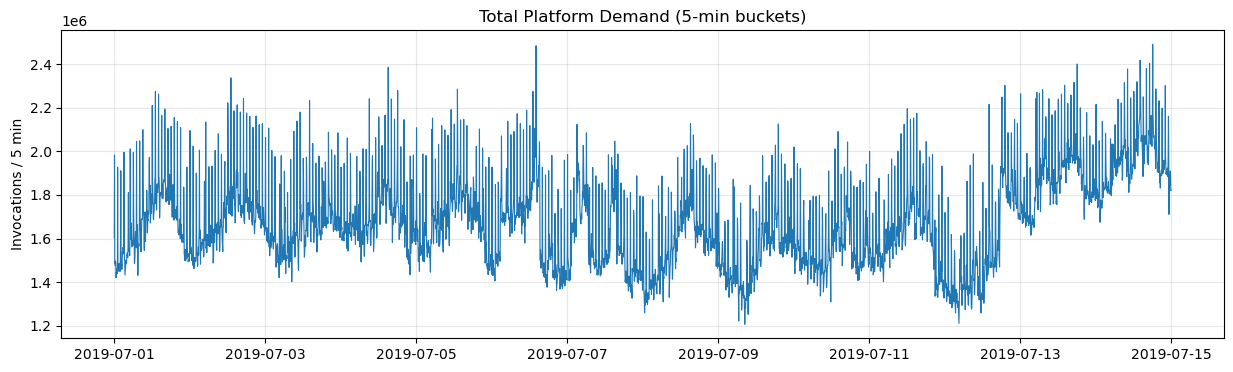

In [7]:
'''
================================
SANITY CHECK
================================
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(series_total["ds"], series_total["y"], linewidth=0.8)
plt.title("Total Platform Demand (5-min buckets)")
plt.ylabel("Invocations / 5 min")
plt.grid(alpha=0.3)
plt.show()

In [8]:
"""
=============================================================================
STEP 5: FORECAST PLATFORM DEMAND (CAPACITY PLANNING) TEST/TRAIN BSPLIT + PROPHET MODEL
=============================================================================

BUSINESS CONTEXT (what to say):
- CO+I teams need to predict near-term demand to prevent capacity shortfalls
  and reduce over-provisioning.
- We forecast total invocations at 5-minute cadence (matches monitoring/autoscale
  cadence; we already smoothed 1-min noise into 5-min buckets).

EVALUATION APPROACH:
- Time-based split to avoid leakage:
  - Train: Days 1–12
  - Test:  Days 13–14 (holdout)
- This mimics real operations: you train on historical data, forecast future.

WHY PROPHET:
- Handles seasonality well (daily/weekly patterns common in workloads).
- Provides uncertainty intervals (useful for risk-aware capacity planning).
=============================================================================
"""

from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd

# --- time-based split ---
cutoff = pd.Timestamp("2019-07-13 00:00:00")  # start of day 13
train = series_total[series_total["ds"] < cutoff].copy()
test  = series_total[series_total["ds"] >= cutoff].copy()

print("Train range:", train["ds"].min(), "->", train["ds"].max(), "rows:", len(train))
print("Test range: ", test["ds"].min(),  "->", test["ds"].max(),  "rows:", len(test))

# Prophet expects columns: ds (datetime), y (numeric)
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode="multiplicative",  # often good when variance scales with level
    changepoint_prior_scale=0.05        # smooth trend; adjust later if needed
)

print("\n⏳ Training Prophet...")
m.fit(train)

print("⏳ Forecasting on test window...")
fcst = m.predict(test[["ds"]])

# --- metrics ---
y_true = test["y"].values
y_pred = fcst["yhat"].values

mape = mean_absolute_percentage_error(y_true, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = np.mean(np.abs(y_true - y_pred))

print("\n" + "="*60)
print("FORECAST BACKTEST RESULTS (Holdout: Days 13–14)")
print("="*60)
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE:  {mae:,.0f}")

# Package results for later anomaly logic / plots
results = test.copy()
results["yhat"] = y_pred
results["yhat_lower"] = fcst["yhat_lower"].values
results["yhat_upper"] = fcst["yhat_upper"].values
results["residual"] = results["y"] - results["yhat"]

results.head()


Train range: 2019-07-01 00:00:00 -> 2019-07-12 23:55:00 rows: 3456
Test range:  2019-07-13 00:00:00 -> 2019-07-14 23:55:00 rows: 576

⏳ Training Prophet...


21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing


⏳ Forecasting on test window...

FORECAST BACKTEST RESULTS (Holdout: Days 13–14)
MAPE: 11.96%
RMSE: 278,259
MAE:  238,141


,ds,y,yhat,yhat_lower,yhat_upper,residual
3456,2019-07-13 00:00:00,1858728,1.601508e+06,1.396147e+06,1.790340e+06,257219.946962
3457,2019-07-13 00:05:00,2263185,1.600864e+06,1.396761e+06,1.794484e+06,662320.602807
3458,2019-07-13 00:10:00,1783487,1.600269e+06,1.415493e+06,1.796757e+06,183217.892311
3459,2019-07-13 00:15:00,1760627,1.599723e+06,1.409148e+06,1.786449e+06,160903.903594
3460,2019-07-13 00:20:00,1766125,1.599227e+06,1.410008e+06,1.791456e+06,166897.654751


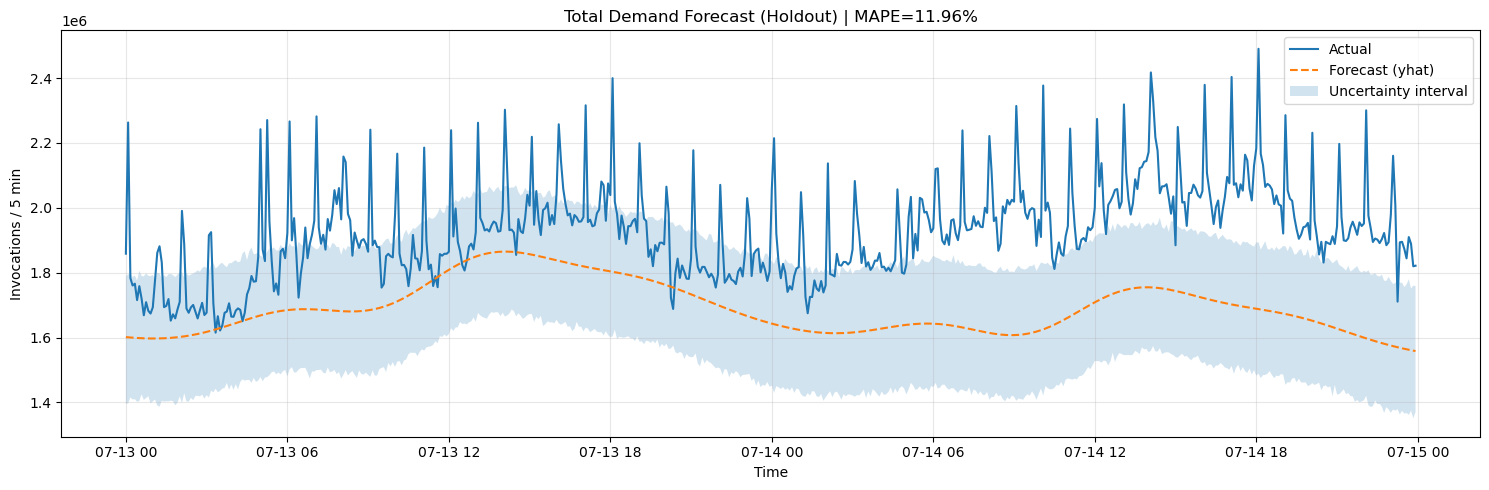

✅ Saved: forecast_holdout.png


In [9]:
"""
=============================================================================
PLOT: ACTUAL vs FORECAST + UNCERTAINTY
=============================================================================

What to say:
- The forecast tracks expected demand patterns.
- The interval gives risk bounds (upper bound is useful for capacity buffer).
=============================================================================
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(results["ds"], results["y"], label="Actual", linewidth=1.5)
plt.plot(results["ds"], results["yhat"], label="Forecast (yhat)", linewidth=1.5, linestyle="--")
plt.fill_between(results["ds"], results["yhat_lower"], results["yhat_upper"], alpha=0.2, label="Uncertainty interval")
plt.title(f"Total Demand Forecast (Holdout) | MAPE={mape:.2f}%")
plt.xlabel("Time")
plt.ylabel("Invocations / 5 min")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("forecast_holdout.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved: forecast_holdout.png")


In [10]:
"""
=============================================================================
STEP 6: ANOMALY DETECTION (OPS ALERTING)
=============================================================================

OPS IDEA:
An anomaly isn't just "high load"—it's "unexpected load" relative to forecast.
So we use forecast residuals and interval breaches.

We create 2 alert types:
1) Interval breach: actual > yhat_upper  (high-side unexpected spike)
2) Residual z-score: |residual| > 3 std (statistical outlier)

Why this is CO+I-aligned:
- Matches how monitoring/alerting works: model-based baselines + thresholds.
- Reduces false alerts vs naive thresholds.
=============================================================================
"""

# 1) Interval breach anomalies (high-side)
results["anomaly_breach"] = (results["y"] > results["yhat_upper"]).astype(int)

# 2) Residual z-score anomalies
resid_std = results["residual"].std()
resid_mean = results["residual"].mean()

results["resid_z"] = (results["residual"] - resid_mean) / (resid_std + 1e-9)
results["anomaly_z3"] = (results["resid_z"].abs() > 3).astype(int)

# Combine: any anomaly
results["anomaly_any"] = ((results["anomaly_breach"] == 1) | (results["anomaly_z3"] == 1)).astype(int)

# Basic severity score (simple + explainable)
# Higher if it breaches interval and/or has large z-score
results["severity"] = (
    1.0 * results["anomaly_breach"]
    + 0.5 * results["anomaly_z3"]
    + 0.1 * results["resid_z"].abs()
)

print("Anomalies (breach):", results["anomaly_breach"].sum())
print("Anomalies (z>3):   ", results["anomaly_z3"].sum())
print("Anomalies (any):   ", results["anomaly_any"].sum())

# Show top 10 most severe anomalies
results.sort_values("severity", ascending=False).head(10)[
    ["ds", "y", "yhat", "yhat_upper", "residual", "resid_z", "anomaly_breach", "anomaly_z3", "severity"]
]


Anomalies (breach): 320
Anomalies (z>3):    5
Anomalies (any):    320


,ds,y,yhat,yhat_upper,residual,resid_z,anomaly_breach,anomaly_z3,severity
3961,2019-07-14 18:05:00,2490338,1.687752e+06,1.894033e+06,802585.736375,3.889998,1,1,1.889000
3865,2019-07-14 10:05:00,2377128,1.625313e+06,1.829186e+06,751814.829236,3.540563,1,1,1.854056
3853,2019-07-14 09:05:00,2314121,1.607926e+06,1.812542e+06,706195.284392,3.226583,1,1,1.822658
4009,2019-07-14 22:05:00,2300677,1.597605e+06,1.802140e+06,703071.749661,3.205085,1,1,1.820509
3949,2019-07-14 17:05:00,2403547,1.702124e+06,1.901244e+06,701423.166723,3.193739,1,1,1.819374
3913,2019-07-14 14:05:00,2417462,1.754845e+06,1.944212e+06,662617.283862,2.926654,1,0,1.292665
3457,2019-07-13 00:05:00,2263185,1.600864e+06,1.794484e+06,662320.602807,2.924612,1,0,1.292461
3937,2019-07-14 16:05:00,2379244,1.720999e+06,1.925663e+06,658245.490140,2.896565,1,0,1.289656
3973,2019-07-14 19:05:00,2285737,1.672775e+06,1.881547e+06,612961.841365,2.584897,1,0,1.258490
3829,2019-07-14 07:05:00,2238814,1.631251e+06,1.836428e+06,607563.380071,2.547741,1,0,1.254774


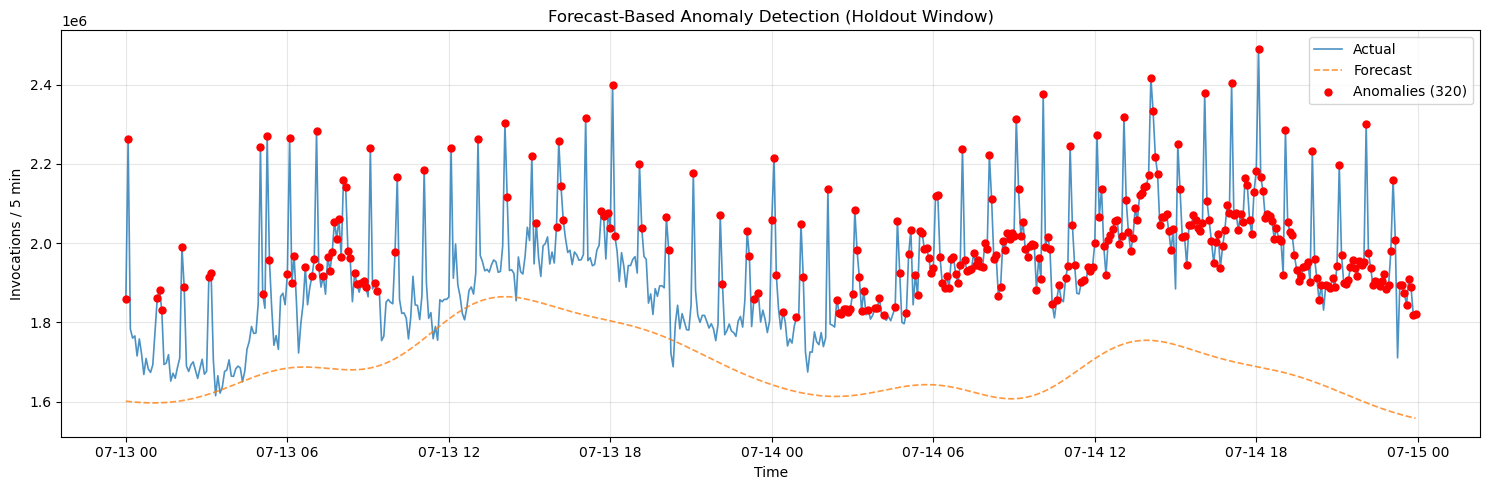

✅ Saved: anomalies_holdout.png


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(results["ds"], results["y"], label="Actual", linewidth=1.2, alpha=0.8)
plt.plot(results["ds"], results["yhat"], label="Forecast", linewidth=1.2, linestyle="--", alpha=0.8)

anom = results[results["anomaly_any"] == 1]
plt.scatter(anom["ds"], anom["y"], color="red", s=25, label=f"Anomalies ({len(anom)})", zorder=5)

plt.title("Forecast-Based Anomaly Detection (Holdout Window)")
plt.xlabel("Time")
plt.ylabel("Invocations / 5 min")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("anomalies_holdout.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved: anomalies_holdout.png")


In [14]:
print(results.columns.tolist())
print(results.shape)
print(results.head(2))



['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'residual', 'anomaly_breach', 'resid_z', 'anomaly_z3', 'anomaly_any', 'severity']
(576, 11)
                      ds        y          yhat    yhat_lower    yhat_upper  \
3456 2019-07-13 00:00:00  1858728  1.601508e+06  1.396147e+06  1.790340e+06   
3457 2019-07-13 00:05:00  2263185  1.600864e+06  1.396761e+06  1.794484e+06   

           residual  anomaly_breach   resid_z  anomaly_z3  anomaly_any  \
3456  257219.946962               1  0.136475           0            1   
3457  662320.602807               1  2.924612           0            1   

      severity  
3456  1.013648  
3457  1.292461  


In [15]:
#export data
import os

export_path = os.path.expanduser("~/Downloads/Resume_Projects/cloud-capacity-powerbi/data")
os.makedirs(export_path, exist_ok=True)

results[[
    "ds", "y", "yhat", "yhat_lower", "yhat_upper",
    "residual", "resid_z", "anomaly_breach", "anomaly_z3", "anomaly_any", "severity"
]].to_csv(os.path.join(export_path, "forecast_results.csv"), index=False)

print(f"✓ forecast_results.csv saved — {len(results)} rows")




✓ forecast_results.csv saved — 576 rows
